Script to combine JSON simulation result files into a unified results structure.

Each input file must follow the naming convention:
    `{name}_sim{sim_id}_{timestamp}.json`

and contain a JSON object with keys:
- scenario_name: str
- sim_id: int
- agent_names: list of str
- cum_regrets: list of lists (one per agent)
- time_agents: list of lists (one per agent)

The script aggregates data across multiple files for the same scenario and sim_id,
producing a `results` dict:

```
results[scenario_name] = {
    "scenario_name": scenario_name,
    "sim_id": [list of sim_ids],
    "regrets": {agent_name: np.ndarray of shape (n_simulations, n_draws)},
    "times": {agent_name: np.ndarray of shape (n_simulations, n_draws)},
}
```

## Pre

In [1]:
import os, glob, json, re, numpy as np

def load_and_combine(json_dir='.', exclude=None):
    def ex_pred(x):
        if exclude is None: return False
        if isinstance(exclude, str): return re.search(exclude, x) is not None
        if hasattr(exclude, 'search'): return exclude.search(x) is not None
        return x in set(exclude)  # iterable of names

    files_data, seen_rand = {}, set()
    for fp in glob.glob(os.path.join(json_dir, '*.json')):
        d = json.load(open(fp))
        sc, sid, names = d['scenario_name'], d['sim_id'], d['agent_names']
        A, T = np.array(d['cum_regrets']), np.array(d['time_agents'])
        key = (sc, sid)

        mask = [not ex_pred(n) and not (key in seen_rand and n == 'Random') for n in names]
        if not any(mask): 
            if 'Random' in names: seen_rand.add(key)  # still mark if present
            continue
        if 'Random' in names: seen_rand.add(key)

        idx = np.nonzero(mask)[0]
        files_data.setdefault(sc, {}).setdefault(sid, []).append({
            'agent_names': [names[i] for i in idx],
            'cum_regrets': A[:, idx],
            'time_agents': T[:, idx],
        })

    results = {}
    for sc, sims in files_data.items():
        all_agents = sorted({n for es in sims.values() for e in es for n in e['agent_names']})
        sim_ids = sorted(sims.keys())
        n_sim, n_draws = max(sim_ids) + 1, len(sims[sim_ids[0]][0]['cum_regrets'])
        R = {n: np.zeros((n_sim, n_draws)) for n in all_agents}
        S = {n: np.zeros((n_sim, n_draws)) for n in all_agents}
        for sid, es in sims.items():
            for e in es:
                A, T = e['cum_regrets'], e['time_agents']
                for i, n in enumerate(e['agent_names']):
                    R[n][sid], S[n][sid] = A[:, i], T[:, i]
        results[sc] = {'scenario_name': sc, 'sim_id': sim_ids, 'regrets': R, 'times': S}
    return results

In [2]:
combined = load_and_combine('./results/compare_all', exclude = r'^(?=.*BART.*)(?!^RefreshBARTs$).*$')

In [3]:
from compare_agents import print_summary_results, print_topn_agents_per_scenario, print_pairwise_win_tie_lose, print_relative_performance, plot_print_total_regret_factors, print_relative_performance, plot_comparison_results

In [4]:
combined = {k: combined[k] for k in [
    # "Linear",
    # "Friedman",
    # "LinFriedman",
    # "Friedman2",
    # "Friedman3",
    "Magic",
    "Shuttle",
    "Adult",
    "Mushroom",
    # "Iris",
    # "Wine",
    # "Heart"
    ] if k in combined}

## Printed Info

In [5]:
print_summary_results(combined)


Final cumulative regrets (mean ± std) by Agent (rows) and Scenario (columns):
                        Magic          Shuttle            Adult         Mushroom
LinearTS      2191.00 ± 28.14  1386.38 ± 18.90  1945.00 ± 51.33    549.00 ± 8.53
RFTS          1585.50 ± 27.14  458.25 ± 656.62  1643.88 ± 37.62    63.38 ± 14.26
Random        4965.62 ± 42.22  8555.00 ± 28.20  4991.62 ± 43.83  4069.00 ± 31.83
RefreshBARTs  1516.62 ± 30.85   154.00 ± 35.39  1571.50 ± 22.59     54.25 ± 9.72
XGBoostTS     1583.00 ± 37.35   160.50 ± 46.25  1569.25 ± 43.21    79.25 ± 12.87

Average computation times (seconds; mean ± std) by Agent (rows) and Scenario (columns):
                          Magic             Shuttle               Adult           Mushroom
LinearTS        1.5498 ± 0.0543     1.9049 ± 0.0525     1.7127 ± 0.0606    1.5187 ± 0.0939
RFTS          178.5183 ± 0.7979   280.1980 ± 3.8402   154.4287 ± 1.5075  117.5924 ± 1.9974
Random          0.1525 ± 0.0044     0.1536 ± 0.0079     0.1449 ± 0.0042  

In [6]:
print_topn_agents_per_scenario(combined, 5)


Top 5 agents per scenario:
               Magic       Shuttle         Adult      Mushroom
Rank 1  RefreshBARTs  RefreshBARTs     XGBoostTS  RefreshBARTs
Rank 2     XGBoostTS     XGBoostTS  RefreshBARTs          RFTS
Rank 3          RFTS          RFTS          RFTS     XGBoostTS
Rank 4      LinearTS      LinearTS      LinearTS      LinearTS
Rank 5        Random        Random        Random        Random


In [7]:
print_pairwise_win_tie_lose(combined)


Pairwise win-tie-lose matrix with totals (row vs column):
Format: win-tie-lose (lower regret wins)
             LinearTS   RFTS RefreshBARTs XGBoostTS   Total
LinearTS          ---  0-1-4        0-1-4     0-1-4  0-3-12
RFTS            4-1-0    ---        0-3-2     1-3-1   5-7-3
RefreshBARTs    4-1-0  2-3-0          ---     2-3-0   8-7-0
XGBoostTS       4-1-0  1-3-1        0-3-2       ---   5-7-3


In [8]:
print_relative_performance(combined)


Agent performance (relative to LinearTS):
Agent                         Mean       SE Std (stability)
-----------------------------------------------------------
RefreshBARTs                 0.183    0.188    0.375
XGBoostTS                    0.220    0.184    0.368
RFTS                         0.281    0.170    0.339
LinearTS                     1.000    0.000    0.000
Random                       3.547    1.290    2.579


In [9]:
print_relative_performance(combined, "times")


Agent performance (relative to LinearTS):
Agent                         Mean       SE Std (stability)
-----------------------------------------------------------
Random                       0.141    0.008    0.016
LinearTS                     1.658    0.089    0.177
XGBoostTS                  114.690    5.201   10.402
RFTS                       165.631   34.835   69.670
RefreshBARTs               227.166   22.077   44.153


## Plot & Print

In [10]:
# plot_print_total_regret_factors(combined)

## "Beautiful" Plots

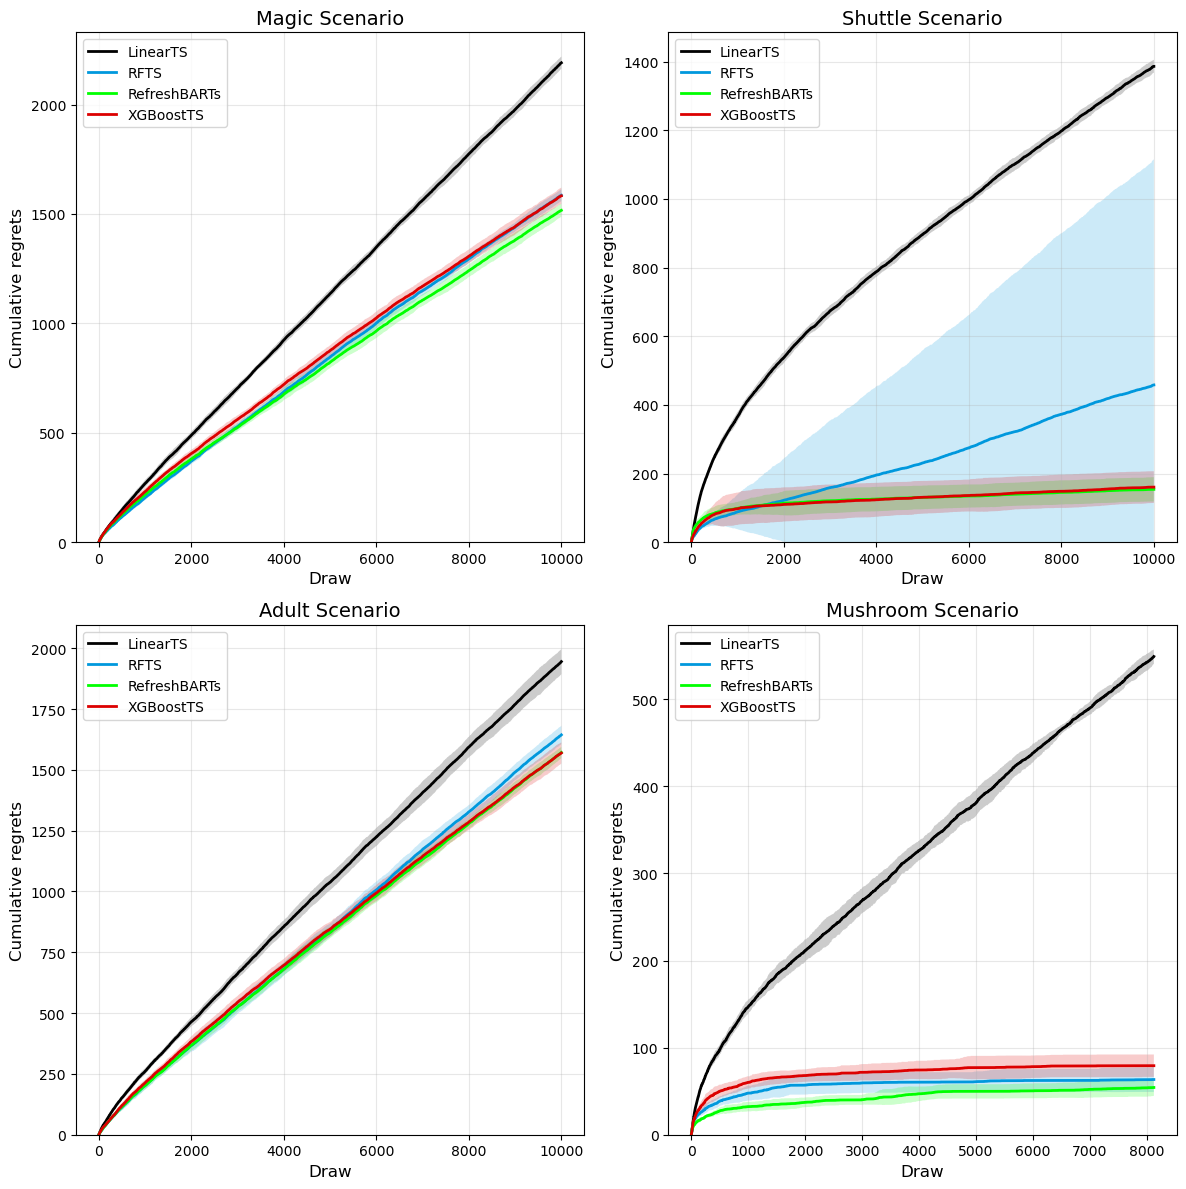

In [11]:
plot_comparison_results(combined, show_random=False)

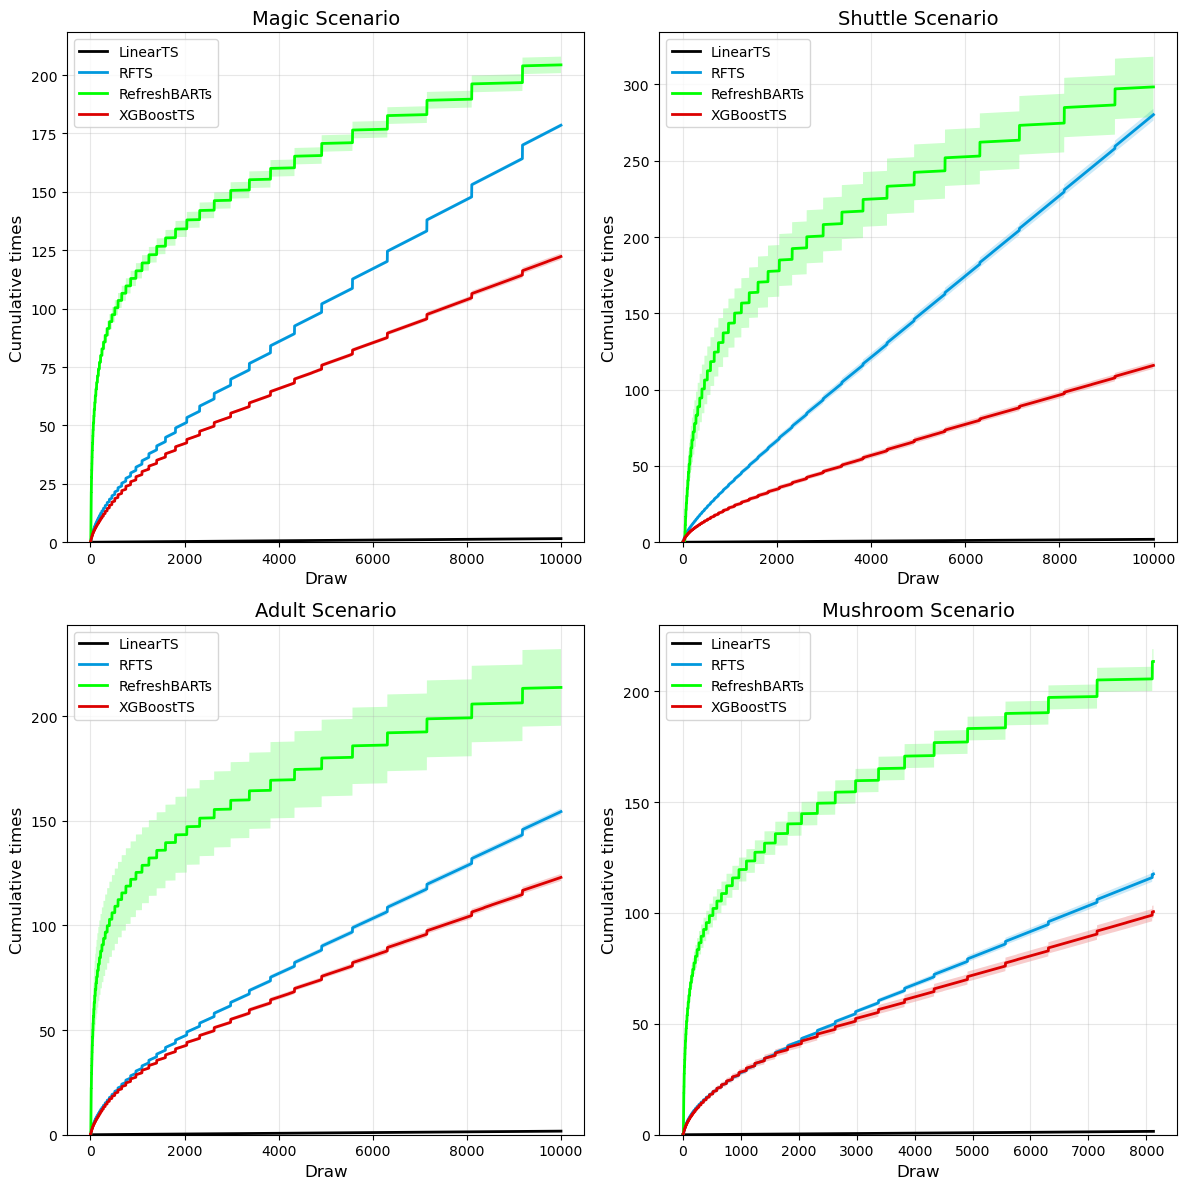

In [12]:
plot_comparison_results(combined, show_random=False, target="times")